##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural Machine Translation with Attention

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import csv

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu, corpus_bleu

In [41]:
from data_loader import load_dataset, max_length, convert, preprocess_sentence
from model import Encoder, Decoder, BahdanauAttention
from evaluate_validate import translate, evaluate, validate, estimate_corpus_bleu

## Download and prepare the dataset

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-ZäöüÄÖÜß?.!,]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = "<start> " + w + " <end>"
    return w

In [5]:
# ---- Experiment: Testing the sentence preprocessing

en_sentence = u"What is the time?"
ge_sentence = u"Wo ist myne apfel?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ge_sentence).encode('utf-8'))

<start> what is the time ? <end>
b'<start> wo ist myne apfel ? <end>'


In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return sentence pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    # read lines from file
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    # generate cleaned setence pairs
    sentence_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*sentence_pairs)

In [7]:
# ---- Experiment: Read sentence pairs from the input text file 

# TODO: define path
path_to_file = "./eng-ger.txt"

# Specify the num_examples to limit how many sentences are read in
# en, ge = create_dataset(path_to_file, 50000)

# # Check the dataset
# print('Number of sentence pairs in text file: {} \nSample formatted sentences: '.format(len(en)))
# print(en[40000])
# print(ge[40000])

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
# Input parameters:
#         - lang: this is an array of sentences from a single language
# returns:
#         - tensor: this is the set of those same sentences but vectorised (each word is now represetned by its unique id)
#         - lang_tokenizer: 
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
            filters='')
    
    # Creates an internal vocabulary for lang     
    lang_tokenizer.fit_on_texts(lang)

    # Uses the tokeniser to vectorise the entire input language
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    # Pads all the sequences in the tensor to the same length (max sentence length)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                                                                                 padding='post')

    return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output sentence pairs
    # input : English     
    # target : German
    
    # get sentence pairs
    inp_lang, targ_lang = create_dataset(path, num_examples)

    # tokenise/vectorise sentence pairs
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
# Try experimenting with the size of that dataset
num_examples = 150000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
# Creating training and validation sets using an 90-10 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

135000 135000 15000 15000


In [13]:
def convert(lang, tensor):
    for unique_id in tensor:
        if unique_id!=0:
            # method to go from index to word
            print ("%d \t----> %s" % (unique_id, lang.index_word[unique_id]))

In [14]:
# ---- Experiment with converting returned tensor to words from the language
# note that inp_lang and targ_lang are tokenisers

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[1000])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[1000])

Input Language; index to word mapping
1 	----> <start>
24 	----> don
11 	----> t
35 	----> be
223 	----> late
30 	----> for
112 	----> work
3 	----> .
2 	----> <end>

Target Language; index to word mapping
1 	----> <start>
361 	----> komm
9 	----> nicht
14 	----> zu
283 	----> spat
30 	----> auf
146 	----> arbeit
19 	----> !
2 	----> <end>


### Create a tf.data dataset

In [15]:
BUFFER_SIZE = len(input_tensor_train)                    #size of the dataset
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE    #number of batches
number_val_batches  = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 256                                      #embedding dimension for word embeddings (first layer in encoder and decoder model)
units = 1024                                             #dimension of the hidden state (and output space) of encoder and decoder
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

print("Size of input vocabulary: {}".format(vocab_inp_size))
print("Size of target vocabulary: {}".format(vocab_tar_size))

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Size of input vocabulary: 11826
Size of target vocabulary: 23726


### Create a tf.data validation dataset

In [16]:
validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(validation_dataset))
example_input_batch.shape, example_target_batch.shape


(TensorShape([Dimension(64), Dimension(15)]),
 TensorShape([Dimension(64), Dimension(24)]))

## Write the encoder and decoder model

### Description of the model


Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

### Encoder, Decoder

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # default activation is tanh
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                        return_sequences=True,    # returns output at each step
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        # try bidirectional
        # try LSTM

    # The GRU processes a batch at a time, therefore it returns a 3 dimensional output tensor (batch_size, sequence length, units)
    # which captures the hidden state of the GRU at each timestep, for every sentence in the batch
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
# ---- Extract a sample from the database
# Note that the size is (batch_size, sequence_length)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(64), Dimension(15)]),
 TensorShape([Dimension(64), Dimension(24)]))

In [19]:
# ---- Initialise the ENCODER

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Experiment with a sample input 
# Note that the size of the output has 11 dimensions. This is becuase the output at each timestep is being returned (return_sequence = True)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [20]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [21]:
attention_layer = BahdanauAttention(10)
context_vector, attention_weights = attention_layer(sample_hidden, sample_output)

print("Context vector shape: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Context vector shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                                                     return_sequences=True,
                                                                     return_state=True,
                                                                     recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [23]:
# ---- Experiment with the decoder

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

# Decoder output is the size of the target language vocabulary for each of the 
# inputs it is given (in this case a batch of 64)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 23726)


### Define the optimizer and the loss function

In [24]:
# Optimiser
optimizer = tf.keras.optimizers.Adam()

# Loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoints (Object-based saving)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


local_checkpoint_dir = "./checkpoint"
local_checkpoint_prefix = os.path.join(local_checkpoint_dir, "ckpt")

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def validation_step(inp, targ, enc_hidden):
    loss = 0

    # Encoder output shape: (batch size, sequence length, units) (64, 14, 1024)
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # Encoder Hidden state shape: (batch size, units) (64, 1024)
    dec_hidden = enc_hidden

    # Insert the index for <start> token for every sentences in the batch
    # Decoder output shape: (batch_size, vocab size) (64, 16912)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)


    for t in range(1, targ.shape[1]):
        # Passing enc_output to the decoder for the attention mechanism
        # and processing an entire batch at once
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        print(targ[:, t])
        loss += loss_function(targ[:, t], predictions)

        # Teacher forcing - feeding the target as the next input
        # Note: ignoring the predictions generated due to teacher forcing
        # Note: that targ is a batch of setences. Therefore take the correct word 
        # for each sentence in the batch at this timestep
        # and feed it to the next timestep.
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    return batch_loss

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        # Encoder output shape: (batch size, sequence length, units) (64, 14, 1024)
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # Encoder Hidden state shape: (batch size, units) (64, 1024)
        dec_hidden = enc_hidden

        # Insert the index for <start> token for every sentences in the batch
        # Decoder output shape: (batch_size, vocab size) (64, 16912)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        
        for t in range(1, targ.shape[1]):
            # Passing enc_output to the decoder for the attention mechanism
            # and processing an entire batch at once
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            print(targ[:, t])
            loss += loss_function(targ[:, t], predictions)

            # Teacher forcing - feeding the target as the next input
            # Note: ignoring the predictions generated due to teacher forcing
            # Note: that targ is a batch of setences. Therefore take the correct word 
            # for each sentence in the batch at this timestep
            # and feed it to the next timestep.
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [43]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # Clean the sentence (remove some characters and split the punctuation)
    sentence = preprocess_sentence(sentence)

    # Split the sentence up into words and then map each word to its word-id
    inputs = [inp_lang.word_index[word] for word in sentence.split(" ")]

    # Pad the list to maximum input length
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_length_inp, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    hidden = [tf.zeros((1, units))]

    # Pass input to encoder
    enc_out, enc_hidden = encoder(inputs, hidden)

    # Initialise decoder hidden state with the encoder's and start
    dec_hidden = enc_hidden

    # Add a batch dimension to a single element
    dec_input = tf.expand_dims([targ_lang.word_index["<start>"]], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(
            dec_input, dec_hidden, enc_out
        )

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        # Grab the most likely prediction
        predicted_id = tf.argmax(predictions[0]).numpy()

        # Convert id to word and add to the result sentence
        result += targ_lang.index_word[predicted_id] + " "

        if targ_lang.index_word[predicted_id] == "<end>":
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap="viridis")

    fontdict = {"fontsize": 14}

    ax.set_xticklabels([""] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([""] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig('./output_plots/attention_'+''.join(sentence[1:-2]) + '.png')
    # plt.show()


'''Uses trained network to translate input sentence and plots attention weights'''


def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print("Input: %s" % (sentence))
    print("Predicted translation: {}".format(result))

    attention_plot = attention_plot[
        : len(result.split(" ")), : len(sentence.split(" "))
    ]
    plot_attention(attention_plot, sentence.split(" "), result.split(" "))


'''Returns sentence pair as lists from validation set as index x (input, target) '''


def getValidationPair(x):
    '''Using index x, retrieve the input and target validation pair '''
    inp_sentence = []
    for index in input_tensor_val[x]:
        if index > 2:
            inp_sentence.append(inp_lang.index_word[index])

    targ_sentence = []
    for index in target_tensor_val[x]:
        if index > 2:
            targ_sentence.append(targ_lang.index_word[index])

    return inp_sentence, targ_sentence


def validate(key):
    inp, targ = getValidationPair(key)

    print('Ground truth sentence: {}'.format(" ".join(targ)))
    result, sentence, attention_plot = evaluate(" ".join(inp))
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print('Ground truth: {}'.format(targ))
    print('Predicted translation: {}'.format(result.split(' ')[:-2]))


'''Returns a pair of tuples - the ground truth and predicted sentence'''


def gt_vs_prediction(key):
    inp, targ = getValidationPair(key)
    result, sentence, attention_plot = evaluate(" ".join(inp))
    return targ, result.split(' ')[:-2]


'''Estimates BLUE score for the translations using up to 1000 samples from validation set'''


def estimate_corpus_bleu():
    list_references = []
    list_hypotheses = []

    range_end = len(input_tensor_val) if (
        len(input_tensor_val) < 1000) else 1000

    for i in range(0, range_end):
        ground_truth, prediction = gt_vs_prediction(i)
        list_references.append([ground_truth])
        list_hypotheses.append(prediction)

    # for i, prediction in enumerate(list_hypotheses):
    #   print(list_references[i], '\t', prediction)

    return corpus_bleu(list_references, list_hypotheses)

In [0]:
EPOCHS = 10
batch_losses = []
training_losses = []
validation_losses = []

# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_val_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # batch: a counting variable for the batch number
        # inp:     the set of [BATCH SIZE] vectorised input sentences
        # targ:    the set of [BATCH SIZE] vectorised target sentences        
        
        batch_loss = train_step(inp, targ, enc_hidden)
        batch_losses.append(batch_loss.numpy())
        total_loss += batch_loss

        if batch % 100 == 0:
                print('Epoch {} Batch {}/{} Loss {:.4f}'.format(epoch + 1,
                                                                batch,
                                                                steps_per_epoch,     
                                                                batch_loss.numpy()))
    
    print("----------------------------------------")
    
    # Validation Losses each epoch                 
    for (inp, targ) in validation_dataset:
        val_batch_loss = validation_step(inp, targ, enc_hidden)
        total_val_loss += batch_loss
        
    total_val_loss = (total_val_loss/number_val_batches).numpy()
    validation_losses.append(total_val_loss)
    
    # Test model accuracy on the validation data     
    bleu_score = estimate_corpus_bleu()
        
    # Saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        checkpoint.save(file_prefix = local_checkpoint_prefix)
        
    epoch_loss = total_loss / steps_per_epoch
    training_losses.append(epoch_loss)

    print('Epoch {}: \n\t- Average Epoch Loss: {:.4f} \n\t- Estimate BLEU Score: {:.4f}'.format(
                                                                            epoch + 1,
                                                                            epoch_loss,
                                                                            bleu_score ))
    print('\t- Validation Loss: {:.4f}'.format(total_val_loss))
    print('\t- Time taken: {:.4f} sec\n'.format(time.time() - start))
    
    print("----------------------------------------")

Epoch 1 Batch 0/703 Loss 1.4345
Epoch 1 Batch 100/703 Loss 1.0980
Epoch 1 Batch 200/703 Loss 1.1341
Epoch 1 Batch 300/703 Loss 1.0899
Epoch 1 Batch 400/703 Loss 1.0151
Epoch 1 Batch 500/703 Loss 0.9816
Epoch 1 Batch 600/703 Loss 0.9036
Epoch 1 Batch 700/703 Loss 0.8504
----------------------------------------
Tensor("strided_slice:0", shape=(64,), dtype=int32)
Tensor("strided_slice_3:0", shape=(64,), dtype=int32)
Tensor("strided_slice_6:0", shape=(64,), dtype=int32)
Tensor("strided_slice_9:0", shape=(64,), dtype=int32)
Tensor("strided_slice_12:0", shape=(64,), dtype=int32)
Tensor("strided_slice_15:0", shape=(64,), dtype=int32)
Tensor("strided_slice_18:0", shape=(64,), dtype=int32)
Tensor("strided_slice_21:0", shape=(64,), dtype=int32)
Tensor("strided_slice_24:0", shape=(64,), dtype=int32)
Tensor("strided_slice_27:0", shape=(64,), dtype=int32)
Tensor("strided_slice_30:0", shape=(64,), dtype=int32)
Tensor("strided_slice_33:0", shape=(64,), dtype=int32)
Tensor("strided_slice_36:0", shape=

In [45]:
# Plot and save the loss information

plt.figure()
plt.plot(batch_losses)
plt.xlabel('Batches')
plt.ylabel('Training Losses')
plt.savefig('training_losses.png')
plt.savefig(local_dir + '/output_plots/training_losses.png')


plt.figure()
plt.plot(validation_losses)
plt.xlabel('Epochs')
plt.ylabel('Validation Losses')
plt.savefig('validation_losses.png')
plt.savefig(local_dir + '/output_plots/training_losses.png')


# Write out batch losses to a CSV file
with open(local_dir + '10_epochs_10000_sentences.csv', 'w') as file:
    csv_writer = csv.writer(file, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(batch_losses)
    csv_writer.writerow(validation_losses)

NameError: name 'batch_losses' is not defined

<Figure size 432x288 with 0 Axes>

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [26]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig(local_dir + '/output_plots/attention_'+''.join(sentence[1:-2]) + '.png')
    plt.show()


In [27]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [28]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint(local_checkpoint_dir))

In [42]:
local_dir = "./local_experiment"
translate(u'I am hungry.')
translate(u'Where can I find a restaurant?')


NameError: name 'np' is not defined

Input: <start> hello , how is your father ? <end>
Predicted translation: hallo , wie geht das ihrem vater ? <end> 


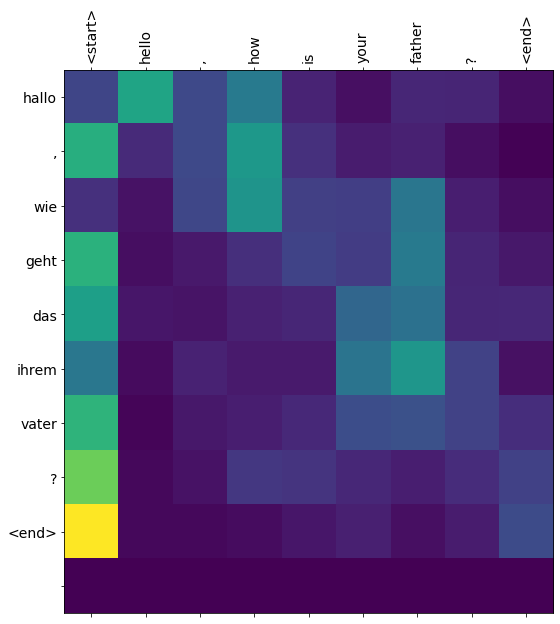

In [77]:
translate(u'Hello, how is your father?')

Input: <start> is this your car ? <end>
Predicted translation: ist dieses auto ihres ? <end> 


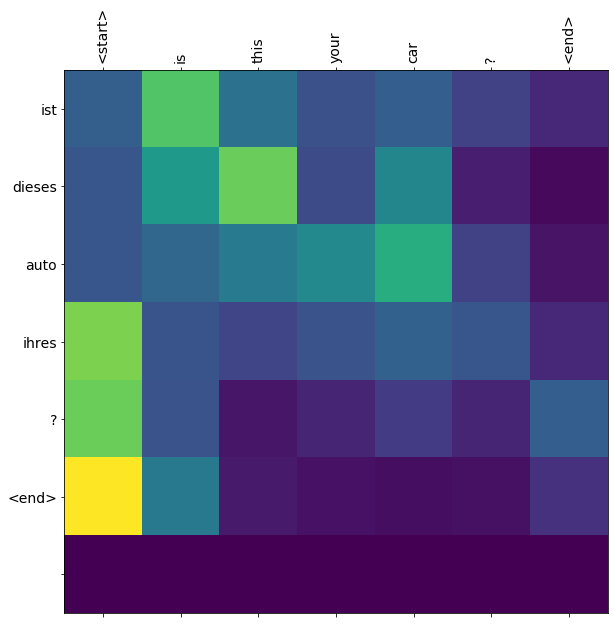

In [59]:
translate(u'Is this your car?')

Input: <start> how do i pay for food ? <end>
Predicted translation: wie zahle ich hinaus ? <end> 


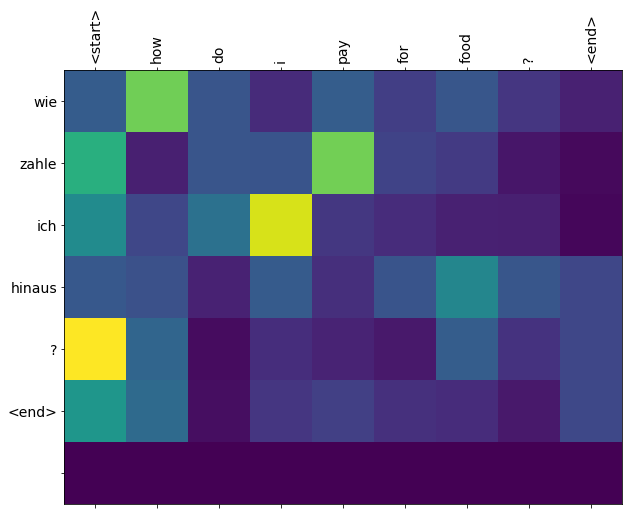

In [69]:
translate(u'How do I pay for food?')

In [89]:
validate(1000)

Input: 		<start> tom hid behind the shower curtain . <end>
Ground Truth: 	tom versteckte sich hinter dem duschvorhang .
Prediction: 	tom versteckte sich hinter dem duschvorhang . <end> 

Ground truth: 	['tom', 'versteckte', 'sich', 'hinter', 'dem', 'duschvorhang', '.']
Predicted translation: ['tom', 'versteckte', 'sich', 'hinter', 'dem', 'duschvorhang', '.']
------------------------------------------------


In [87]:
for phrase in range(30,40):
    validate(phrase)
    print()

Input: 		<start> do you need a ride ? <end>
Ground Truth: 	kann ich dich fahren ?
Prediction: 	kann ich eine mitfahrgelegenheit ? <end> 

Ground truth: 	['kann', 'ich', 'dich', 'fahren', '?']
Predicted translation: ['kann', 'ich', 'eine', 'mitfahrgelegenheit', '?']
------------------------------------------------

Input: 		<start> i kept my mouth shut . <end>
Ground Truth: 	ich hielt den mund .
Prediction: 	ich hielt den mund . <end> 

Ground truth: 	['ich', 'hielt', 'den', 'mund', '.']
Predicted translation: ['ich', 'hielt', 'den', 'mund', '.']
------------------------------------------------

Input: 		<start> actinium is a silvery metal . <end>
Ground Truth: 	actinium ist ein silbernes metall .
Prediction: 	actinium ist ein silbernes metall . <end> 

Ground truth: 	['actinium', 'ist', 'ein', 'silbernes', 'metall', '.']
Predicted translation: ['actinium', 'ist', 'ein', 'silbernes', 'metall', '.']
------------------------------------------------

Input: 		<start> would you please turn 

Input: <start> you turned on the light . <end>
Predicted translation: sie haben sich im licht an . <end> 


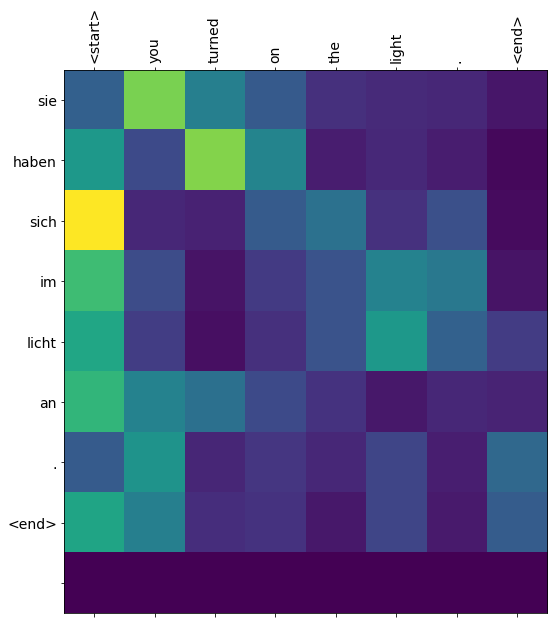

In [39]:
translate(u'You turned on the light.')